In [1]:
import json,os
from web3 import Web3
import krakenex
import requests
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
ADDRESSES_EOA = [
    "0xC6A8109D566D31758329452c626D473B7815380E", #DV
    "0xba42C2DfbB5e876EfD9dBd198DeD5DEB2beD68C5" # PMG2
    # add new ones
]

ADDRESSES_CONTRACTS = [
    "0x14052a178026665BB27fd0Be549f8FB8a88780d4"
] 

In [3]:
# loading API for etherscan and coingecko
# both should be added to api.env file 
# in format
# API_ETHERSCAN=""
# API_KEY_COIN_GECKO=""
dotenv_path = 'api.env'
load_dotenv(dotenv_path)

API_ETHERSCAN=os.getenv("API_ETHERSCAN")
API_KEY_COIN_GECKO =os.getenv("API_KEY_COIN_GECKO")

def get_abi(name):
 
    contract_address=get_token_address(name)

    url = f"https://api.etherscan.io/api?module=contract&action=getabi&address={contract_address}&apikey={API_ETHERSCAN}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        json_response = response.json()

        if json_response['status'] == "1":
            return json_response['result']
        else:
            return None
    else:
        # Request failed
        print(f"Failed to retrieve ABI. Status code: {response.status_code}")
        return None




def get_token_address(token_name):
    tokens = {
        "GNO": "0x6810e776880C02933D47DB1b9fc05908e5386b96",
        "GEL": "0x15b7c0c907e4C6b9AdaAaabC300C08991D6CEA05",
        "COW": "0xDEf1CA1fb7FBcDC777520aa7f396b4E015F497aB",
        "USDC": "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48",
        "SWISE": "0x48C3399719B582dD63eB5AADf12A40B4C3f52FA2",
        "WBTC": "0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599"  
        # Add more tokens here
    } 
    if(token_name=="USDC"): 
       return "0x43506849D7C04F9138D1A2050bbF3A0c054402dd"
    elif(token_name=="SWISE"): 
       return "0xA28C2d79f0c5B78CeC699DAB0303008179815396"
    else:
        return tokens.get(token_name.upper(), "Token not found")



In [4]:
class Portfolio():
    
    USDC_ABI =  get_abi("USDC")
    USDC_CONTRACT_ADDRESS = get_token_address("USDC")

    GNO_ABI = get_abi("GNO")
    GNO_CONTRACT_ADDRESS = get_token_address("GNO")

    # For GEL token
    GEL_ABI = get_abi("GEL")
    GEL_CONTRACT_ADDRESS = get_token_address("GEL")

    # For COW token
    COW_ABI = get_abi("COW")
    COW_CONTRACT_ADDRESS = get_token_address("COW")

    # For SWISE token
    SWISE_ABI = get_abi("SWISE")
    SWISE_CONTRACT_ADDRESS = get_token_address("SWISE")

    # For WBTC token
    WBTC_ABI = get_abi("WBTC")
    WBTC_CONTRACT_ADDRESS = get_token_address("WBTC")

    tokens = ["GNO", "GEL", "COW", "USDC", "SWISE", "WBTC"]

   # RPC_CLIENT = "https://rpc.eth.gateway.fm"
    RPC_CLIENT="https://cloudflare-eth.com/"
    
    def __init__(self, ADDRESSES_EOA, ADDRESSES_CONTRACTS):
        self.ADDRESSES_EOA = ADDRESSES_EOA
        self.ADDRESSES_CONTRACTS = ADDRESSES_CONTRACTS
        
        self.web3 = Web3(Web3.HTTPProvider(Portfolio.RPC_CLIENT))
        self.usdc_contract = self.web3.eth.contract("0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48", abi=Portfolio.USDC_ABI)
        self.gno_contract = self.web3.eth.contract(Portfolio.GNO_CONTRACT_ADDRESS, abi=Portfolio.GNO_ABI)
        self.gel_contract = self.web3.eth.contract(Portfolio.GEL_CONTRACT_ADDRESS, abi=Portfolio.GEL_ABI)
        self.cow_contract = self.web3.eth.contract(Portfolio.COW_CONTRACT_ADDRESS, abi=Portfolio.COW_ABI)
        self.swise_contract = self.web3.eth.contract("0x48C3399719B582dD63eB5AADf12A40B4C3f52FA2", abi=Portfolio.SWISE_ABI)
        self.wbtc_contract = self.web3.eth.contract(Portfolio.WBTC_CONTRACT_ADDRESS, abi=Portfolio.WBTC_ABI)
        
        #ne treba
        # self.client = krakenex.API()
        # self.client.load_key(KRAKEN_KEY)
      
    
    @property
    def ADDRESSES(self):
        return self.ADDRESSES_EOA + self.ADDRESSES_CONTRACTS
    
    def get_onchain_eth_balance_single(self, address):
        return self.web3.eth.get_balance(address)/10**18
    
    def get_onchain_eth_balance_total(self):
        total = 0
        for address in self.ADDRESSES:
            total += self.get_onchain_eth_balance_single(address)
            
        return total
    
    def get_onchain_balance_single(self, address,name):
        # print("token "+token)
        decimal=18
        if(name=="USDC"): decimal=6
        elif(name=="WBTC"): decimal=8
        contract=self.get_contract(name)
        # print(contract)
        return contract.functions.balanceOf(address).call()/10**decimal
  
    
    def get_onchain_balance_total(self,name):
        total = 0
       
        for address in self.ADDRESSES:
            total+=self.get_onchain_balance_single(address,name)
        return total
    
    def get_contract(self, name):
        if name == "USDC":
            return self.usdc_contract
        elif name == "GNO":
            return self.gno_contract
        elif name == "GEL":
            return self.gel_contract
        elif name == "COW":
            return self.cow_contract
        elif name == "SWISE":
            return self.swise_contract
        elif name == "WBTC":
            return self.wbtc_contract
        elif name == "ETH":
            return None  
        else:
            raise ValueError(f"Unknown token: {name}")



    def get_token_id(self,name):
        self.tokens = {
            "GNO": "gnosis",
            "GEL": "gelato",
            "COW": "cow-protocol",
            "USDC": "usd-coin",
            "SWISE": "stakewise",
            "WBTC": "wrapped-bitcoin",
            "ETH" : "ethereum"
        }
        return self.tokens.get(name)

    def get_token_price(self,name):
        token_id=self.get_token_id(name)
        crc = "usd"
        url = f"https://api.coingecko.com/api/v3/simple/price?ids={token_id}&vs_currencies={crc}&x_cg_demo_api_key={API_KEY_COIN_GECKO}"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            if token_id in data:
                return data[token_id]['usd']
            else:
                return None
        else:
            print('Error:', response.status_code)
            return None
            
    def get_total_value_single_address(self, address):
        total_price = 0
      #  print(address)

        eth_balance = self.get_onchain_eth_balance_single(address)
       # print("Balance of ETH is ", eth_balance)
        eth_price = self.get_token_price("ETH")
        #print("Price of ETH is ", eth_price)
        eth_value = eth_balance * eth_price
        #print("Value of ETH is ", eth_value)
        total_price += eth_value
        
        for token in self.tokens:
            if token != "ETH":
                balance = self.get_onchain_balance_single(address, token)
               # print("Balance of token ", token, "is ", balance)
                price = self.get_token_price(token)
               #print("Price of token ", token, "is ", price)
                price_single_token = price * balance
               # print("Value of token ", token, "is ", price_single_token)
                total_price += price_single_token
        return total_price
    
    def get_total_value_portfolio(self):
        total = 0
        for address in self.ADDRESSES:
            total += self.get_total_value_single_address(address)
        return total
    
    def plot_token_values(self):
        token_balances = {
            "GNO": (self.get_onchain_balance_total("GNO")*self.get_token_price("GNO")),
            "GEL": (self.get_onchain_balance_total("GEL")*self.get_token_price("GEL")),
            "COW": (self.get_onchain_balance_total("COW")*self.get_token_price("COW")),
            "USDC": (self.get_onchain_balance_total("USDC")*self.get_token_price("USDC")),
            "SWISE": (self.get_onchain_balance_total("SWISE")*self.get_token_price("SWISE")),
            "WBTC": (self.get_onchain_balance_total("WBTC")*self.get_token_price("WBTC")),
            "ETH":  (self.get_onchain_eth_balance_total()*self.get_token_price("ETH"))
        }
        
        tokens = list(token_balances.keys())
        balances = list(token_balances.values())
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(tokens, balances, color='skyblue')
        plt.xlabel('Token')
        plt.ylabel('Value (USD)')
        plt.title('Token values in Portfolio')
        plt.xticks(rotation=45)
        
        for bar, value in zip(bars, balances):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, round(value, 2), ha='center', va='bottom')

        plt.tight_layout() 
        plt.show()

    def plot_token_distribution(self):
        token_balances = {
            "GNO": self.get_onchain_balance_total("GNO"),
            "GEL": self.get_onchain_balance_total("GEL"),
            "COW": self.get_onchain_balance_total("COW"),
            "USDC": self.get_onchain_balance_total("USDC"),
            "SWISE": self.get_onchain_balance_total("SWISE"),
            "WBTC": self.get_onchain_balance_total("WBTC"),
            "ETH":  self.get_onchain_eth_balance_total()
        }
        
        tokens = list(token_balances.keys())
        balances = list(token_balances.values())
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(tokens, balances, color='skyblue')
        plt.xlabel('Token')
        plt.ylabel('Balance')
        plt.title('Token Distribution in Portfolio')
        plt.xticks(rotation=45)
        

        for bar, value in zip(bars, balances):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, round(value, 2), ha='center', va='bottom')

        plt.tight_layout()  
        plt.show()

    def plot_token_value_percentage(self):
        token_values = {
            "GNO": (self.get_onchain_balance_total("GNO")*self.get_token_price("GNO")),
            "GEL": (self.get_onchain_balance_total("GEL")*self.get_token_price("GEL")),
            "COW": (self.get_onchain_balance_total("COW")*self.get_token_price("COW")),
            "USDC": (self.get_onchain_balance_total("USDC")*self.get_token_price("USDC")),
            "SWISE": (self.get_onchain_balance_total("SWISE")*self.get_token_price("SWISE")),
            "WBTC": (self.get_onchain_balance_total("WBTC")*self.get_token_price("WBTC")),
            "ETH":  (self.get_onchain_eth_balance_total()*self.get_token_price("ETH"))
        }
        
        total_portfolio_value = sum(token_values.values())
        
      
        token_percentages = {token: (value / total_portfolio_value) * 100 for token, value in token_values.items()}
        
        threshold_percentage = 2  
        significant_tokens = {token: percentage for token, percentage in token_percentages.items() if percentage >= threshold_percentage}
        other_percentage = 100 - sum(significant_tokens.values())
        
        if other_percentage > 0:
            significant_tokens['Others'] = other_percentage
 
        plt.figure(figsize=(8, 8))
        patches, texts, _ = plt.pie(significant_tokens.values(), labels=significant_tokens.keys(), autopct='%1.1f%%', startangle=140)
        
        for text in texts:
            text.set_color('lightblue')  
            text.set_fontsize(12)  
            
        plt.title('Token Value percentage in Portfolio (USD)', fontsize=16, color='lightblue') 
        plt.axis('equal') 
        plt.tight_layout()
        plt.show()

    def plot_portfolio_value(self):
        addresses = ["Address 1 EOA", "Address 2 EOA",
                     "Address contract" ] 
        portfolio_values = [self.get_total_value_single_address("0xC6A8109D566D31758329452c626D473B7815380E"), self.get_total_value_single_address("0xba42C2DfbB5e876EfD9dBd198DeD5DEB2beD68C5")
                            ,self.get_total_value_single_address("0x14052a178026665BB27fd0Be549f8FB8a88780d4")] 
        
        plt.figure(figsize=(10, 6))
        bars=plt.bar(addresses, portfolio_values, color='lightgreen')
        plt.xlabel('Addresses')
        plt.ylabel('Portfolio Value (USD)')
        plt.title('Portfolio Value by Address')
        for bar, value in zip(bars, portfolio_values):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, round(value, 2), ha='center', va='bottom')

        plt.tight_layout()  
        plt.show()
        

In [5]:
p = Portfolio(ADDRESSES_EOA,ADDRESSES_CONTRACTS)

In [6]:
# for token in p.tokens:
#     print("Balance of token", token)
#     print(p.get_onchain_balance_single("0x14052a178026665BB27fd0Be549f8FB8a88780d4",token))
#     print(p.get_token_id(token))
#     print(p.get_token_price(token))
#     print("(############################################)")

#print("total value is ",p.get_total_value_single_address("0x14052a178026665BB27fd0Be549f8FB8a88780d4"))

#print("total value is ",p.get_total_value_single_address("0xC6A8109D566D31758329452c626D473B7815380E"))
#p.get_total_value_portfolio()
#p.plot_token_distribution()
#p.plot_portfolio_value()


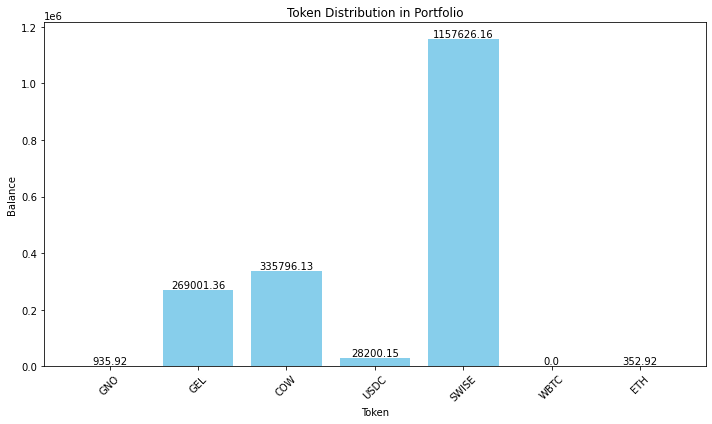

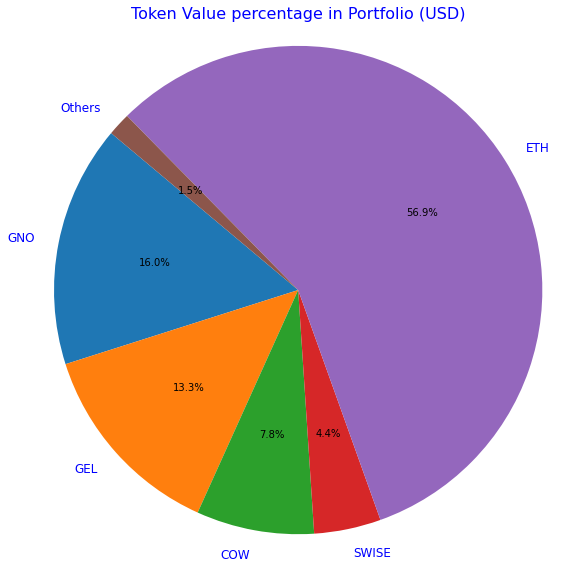

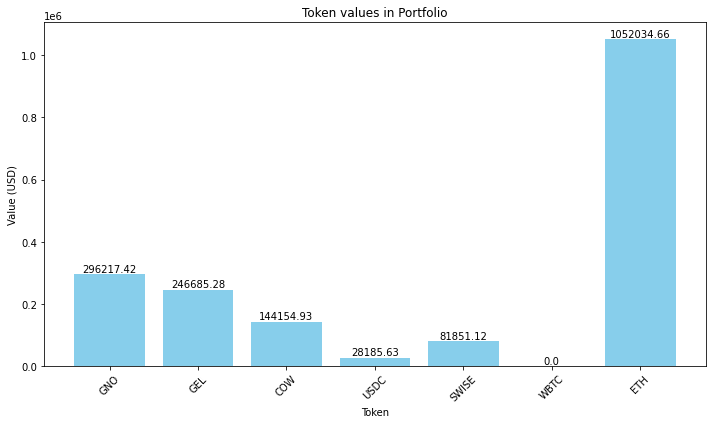

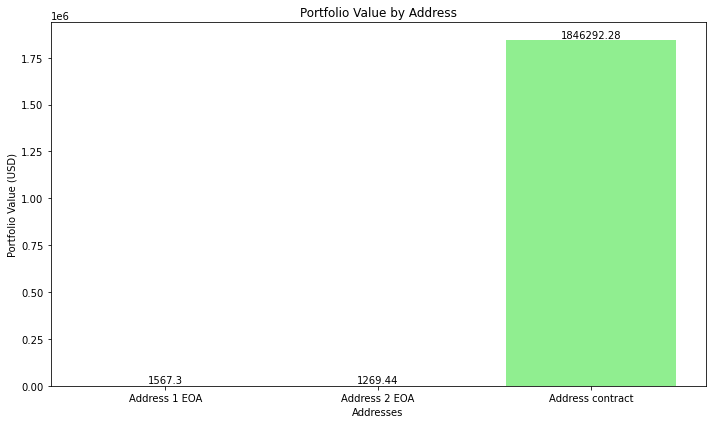

In [7]:
p.plot_token_distribution()
p.plot_token_value_percentage()
p.plot_token_values()
p.plot_portfolio_value()
